Importación de Librerias

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings("ignore")


#Librerias para guardar archivos
import joblib
from pathlib import Path
out_dir = Path.cwd() / "MLPClassifier" #Carpeta para guardar y cargar los modelos de K-means
out_dir.mkdir(parents=True, exist_ok=True)

Función para Importar los datos desde el CSV

In [15]:
def cargar_datos_desde_csv(csv_path='onion_dataset.csv', tamano_imagen=(32, 32)):
    """
    Carga las imágenes desde el CSV y las convierte en vectores de características.
    El CSV debe tener al menos las columnas: 'image_path' y 'class'.
    """
    print("=" * 60)
    print("CARGANDO DATASET")
    print("=" * 60)

    df = pd.read_csv(csv_path)
    print(f"Archivo CSV cargado: {len(df)} imágenes encontradas")

    clases_unicas = df['class'].unique()
    print(f"Clases encontradas: {len(clases_unicas)}")
    for i, clase in enumerate(clases_unicas, 1):
        print(f"   {i}. {clase}")

    X = []
    y = []
    errores = 0

    for idx, fila in df.iterrows():
        try:
            imagen = Image.open(fila['image_path'])

            if imagen.mode != 'RGB':
                imagen = imagen.convert('RGB')

            imagen = imagen.resize(tamano_imagen)
            imagen_array = np.array(imagen).flatten().astype("float32")
            imagen_normalizada = imagen_array / 255.0

            X.append(imagen_normalizada)
            y.append(fila['class'])

            if (idx + 1) % 100 == 0:
                print(f"   Procesadas {idx + 1} imágenes...")

        except Exception as e:
            errores += 1
            print(f"   [ERROR] No se pudo procesar la imagen en fila {idx}: {e}")

    X = np.array(X)
    y = np.array(y)

    print(f"\nTotal de imágenes procesadas correctamente: {len(X)}")
    print(f"Total de errores al cargar imágenes: {errores}")
    print(f"Shape de X: {X.shape}")

    return X, y, clases_unicas

Función para optimizar los hiperparametros

In [16]:
def optimizar_hiperparametros_mlp(X_train, y_train, busqueda_rapida=True):
    """
    Optimiza los hiperparámetros del MLPClassifier usando GridSearchCV.
    Se usa early_stopping para evitar overfitting y acelerar convergencia.
    """
    print("\n" + "=" * 60)
    print("OPTIMIZACIÓN DE HIPERPARÁMETROS - MLPClassifier")
    print("=" * 60)

    modelo_base = MLPClassifier(
        max_iter=80,
        solver="adam",
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5,
        random_state=42
    )

    if busqueda_rapida:
        # Grid moderado para que no se dispare el tiempo
        param_grid = {
            "hidden_layer_sizes": [(128,), (256,), (256, 128)],
            "alpha": [1e-4, 1e-3],
            "learning_rate_init": [1e-3, 5e-4],
            "activation": ["relu"],
            "batch_size": [32, 64],
        }
    else:
        # Búsqueda más amplia (puede tardar mucho más)
        param_grid = {
            "hidden_layer_sizes": [(128,), (256,), (512,),
                                   (256, 128), (512, 256)],
            "alpha": [1e-5, 1e-4, 1e-3, 1e-2],
            "learning_rate_init": [1e-3, 5e-4, 1e-4],
            "activation": ["relu", "tanh"],
            "batch_size": [32, 64, 128],
        }

    grid_search = GridSearchCV(
        estimator=modelo_base,
        param_grid=param_grid,
        scoring="accuracy",
        cv=3,
        n_jobs=-1,
        verbose=2
    )

    grid_search.fit(X_train, y_train)

    print("\nMejores hiperparámetros encontrados:")
    for k, v in grid_search.best_params_.items():
        print(f"   {k}: {v}")

    print(f"\nMejor score de validación (cv): {grid_search.best_score_:.4f}")

    return grid_search.best_params_

Función para entrenar el modelo

In [ ]:
def entrenar_mlp(X_train, y_train, **params):
    """
    Entrena un MLPClassifier con los hiperparámetros dados.
    """
    print("\n" + "=" * 60)
    print("ENTRENANDO MLPClassifier")
    print("=" * 60)

    default_params = {
        "hidden_layer_sizes": (512, 256, 128),  # 3 capas
        "activation": "relu",
        "solver": "adam",
        "alpha": 5e-5,                  # menos regularización
        "learning_rate": "adaptive",    # en vez de 'constant'
        "learning_rate_init": 5e-4,     # LR un poco más bajo
        "batch_size": 64,
        "max_iter": 250,                # más iteraciones permitidas
        "early_stopping": True,
        "validation_fraction": 0.15,    # más datos para validación interna
        "n_iter_no_change": 15,         # más margen antes de parar
        "random_state": 42,
        "verbose": False
    }

    default_params.update(params)

    print("\nParámetros finales del modelo:")
    for k, v in default_params.items():
        print(f"   {k}: {v}")

    modelo = MLPClassifier(**default_params)
    modelo.fit(X_train, y_train)

    print("\nModelo MLP entrenado correctamente.")
    if hasattr(modelo, "loss_curve_"):
        print(f"Número de épocas efectivas: {len(modelo.loss_curve_)}")

    return modelo

Función para evaluar el modelo

In [18]:
def evaluar_modelo(modelo, X_test, y_test, nombres_clases):
    """
    Evalúa el modelo y muestra métricas globales y por clase.
    """
    print("\n" + "=" * 60)
    print("EVALUACIÓN DEL MODELO - MLPClassifier")
    print("=" * 60)

    y_pred = modelo.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nACCURACY GENERAL: {accuracy:.4f} ({accuracy * 100:.2f}%)")

    print("\nREPORTE DETALLADO POR CLASE:")
    print("-" * 60)
    reporte = classification_report(
        y_test,
        y_pred,
        target_names=nombres_clases,
        zero_division=0
    )
    print(reporte)

    matriz = confusion_matrix(y_test, y_pred)

    return accuracy, y_pred, matriz

Función para visualizar la matriz de confusión

In [19]:
def visualizar_matriz_confusion(matriz_confusion, nombres_clases):
    """
    Visualiza y guarda la matriz de confusión.
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        matriz_confusion,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=nombres_clases,
        yticklabels=nombres_clases,
        cbar=True
    )
    plt.title('Matriz de Confusión - MLPClassifier', fontsize=14)
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(out_dir/'matriz_confusion_mlp.png', dpi=100, bbox_inches='tight')
    plt.show()


Función para mostrar la curva de entranamiento

In [20]:
def analizar_curva_entrenamiento(modelo):
    """
    Grafica la curva de pérdida (y si está disponible, la puntuación de validación).
    """
    print("\n" + "=" * 60)
    print("ANÁLISIS DE CURVA DE ENTRENAMIENTO - MLPClassifier")
    print("=" * 60)

    if not hasattr(modelo, "loss_curve_"):
        print("El modelo no tiene atributo 'loss_curve_'. No se puede graficar.")
        return

    epochs = np.arange(1, len(modelo.loss_curve_) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, modelo.loss_curve_, marker='o')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida (loss)')
    plt.title('Curva de entrenamiento (loss) - MLPClassifier')
    plt.grid(True, alpha=0.3)

    # Si el modelo tiene validation_scores_ (por early_stopping)
    if hasattr(modelo, "validation_scores_"):
        val_epochs = np.arange(1, len(modelo.validation_scores_) + 1)
        plt.twinx()
        plt.plot(val_epochs, modelo.validation_scores_, linestyle='--')
        plt.ylabel('Accuracy de validación')

    plt.tight_layout()
    plt.savefig(out_dir/'curva_entrenamiento_mlp.png', dpi=100, bbox_inches='tight')
    plt.show()

Función para predecir una imagen

In [57]:
def predecir_imagen(
    ruta_imagen,
    modelo_path=out_dir/'modelo_mlp.pkl',
    label_encoder_path=out_dir/'label_encoder_mlp.pkl',
    tamano_imagen=(32, 32)
):
    """
    Predice la clase de una nueva imagen usando el MLP entrenado
    y muestra la imagen con la clase y la confianza en el título.

    Returns
    -------
    str : Clase predicha
    """
    try:
        import matplotlib.pyplot as plt

        print("\n" + "=" * 60)
        print("PREDICCIÓN PARA UNA NUEVA IMAGEN - MLPClassifier")
        print("=" * 60)

        # Cargar modelo y LabelEncoder
        modelo = joblib.load(modelo_path)
        label_encoder = joblib.load(label_encoder_path)

        # Cargar imagen original para visualización
        imagen_viz = Image.open(ruta_imagen)
        if imagen_viz.mode != 'RGB':
            imagen_viz = imagen_viz.convert('RGB')

        # Procesar imagen para el modelo
        imagen = imagen_viz.resize(tamano_imagen)
        imagen_array = np.array(imagen).flatten().astype("float32") / 255.0
        imagen_array = imagen_array.reshape(1, -1)

        # Predicción
        prediccion = modelo.predict(imagen_array)[0]
        clase_predicha = label_encoder.inverse_transform([prediccion])[0]

        print(f"\nClase predicha: {clase_predicha}")

        confianza = None

        # Probabilidades usando predict_proba si está disponible
        if hasattr(modelo, "predict_proba"):
            probabilidades = modelo.predict_proba(imagen_array)[0]
            confianza = float(np.max(probabilidades))

            indices_top = np.argsort(probabilidades)[::-1][:3]
            print("\nTop 3 predicciones:")
            for i, idx in enumerate(indices_top):
                clase = label_encoder.inverse_transform([idx])[0]
                prob = probabilidades[idx]
                print(f"   {i + 1}. {clase}: {prob:.2%}")

            print(f"\nConfianza de la clase predicha: {confianza:.2%}")
        else:
            probabilidades = None

        # --- Visualización de la imagen ---
        plt.figure(figsize=(4, 4))
        plt.imshow(imagen_viz)
        plt.axis('off')

        if confianza is not None:
            titulo = f"Predicción (MLP): {clase_predicha}\nConfianza: {confianza*100:.2f}%"
        else:
            titulo = f"Predicción (MLP): {clase_predicha}"

        plt.title(titulo)
        plt.tight_layout()
        plt.show()

        return clase_predicha

    except Exception as e:
        print(f"ERROR en predecir_imagen: {e}")
        return None

Parametros del Modelo

In [27]:
CSV_PATH = 'onion_dataset.csv'
TAMANO_IMAGEN = (32, 32)
TEST_SIZE = 0.2
OPTIMIZAR_PARAMS = False

In [23]:
# 1. Cargar datos
X, y, clases_unicas = cargar_datos_desde_csv(CSV_PATH, TAMANO_IMAGEN)

CARGANDO DATASET
Archivo CSV cargado: 13229 imágenes encontradas
Clases encontradas: 15
   1. Alternaria_D
   2. Botrytis Leaf Blight
   3. Bulb Rot
   4. Bulb_blight-D
   5. Caterpillar-P
   6. Downy mildew
   7. Fusarium-D
   8. Healthy leaves
   9. Iris yellow virus_augment
   10. Purple blotch
   11. Rust
   12. Virosis-D
   13. Xanthomonas Leaf Blight
   14. onion1
   15. stemphylium Leaf Blight
   Procesadas 100 imágenes...
   Procesadas 200 imágenes...
   Procesadas 300 imágenes...
   Procesadas 400 imágenes...
   Procesadas 500 imágenes...
   Procesadas 600 imágenes...
   Procesadas 700 imágenes...
   Procesadas 800 imágenes...
   Procesadas 900 imágenes...
   Procesadas 1000 imágenes...
   Procesadas 1100 imágenes...
   Procesadas 1200 imágenes...
   Procesadas 1300 imágenes...
   Procesadas 1400 imágenes...
   Procesadas 1500 imágenes...
   Procesadas 1600 imágenes...
   Procesadas 1700 imágenes...
   Procesadas 1800 imágenes...
   Procesadas 1900 imágenes...
   Procesadas 20

In [28]:
# 2. Codificar etiquetas
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [29]:
# 3. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=TEST_SIZE,
    random_state=42,
    stratify=y_encoded
)

print(f"\nTamaño de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño de prueba: {X_test.shape[0]} muestras")


Tamaño de entrenamiento: 10583 muestras
Tamaño de prueba: 2646 muestras


In [32]:
# 4. Búsqueda de hiperparámetros
if OPTIMIZAR_PARAMS:
    mejores_params = optimizar_hiperparametros_mlp(
        X_train, y_train,
        busqueda_rapida=True
    )
else:
    mejores_params = {}

In [49]:
# 5. Entrenar modelo final
modelo = entrenar_mlp(X_train, y_train, **mejores_params)


ENTRENANDO MLPClassifier

Parámetros finales del modelo:
   hidden_layer_sizes: (512, 256, 128)
   activation: relu
   solver: adam
   alpha: 5e-05
   learning_rate: adaptive
   learning_rate_init: 0.0005
   batch_size: 64
   max_iter: 250
   early_stopping: True
   validation_fraction: 0.15
   n_iter_no_change: 15
   random_state: 42
   verbose: False

Modelo MLP entrenado correctamente.
Número de épocas efectivas: 107


In [50]:
# 6. Evaluación en test
accuracy, y_pred, matriz = evaluar_modelo(
    modelo,
    X_test,
    y_test,
    nombres_clases=label_encoder.classes_
)


EVALUACIÓN DEL MODELO - MLPClassifier

ACCURACY GENERAL: 0.7029 (70.29%)

REPORTE DETALLADO POR CLASE:
------------------------------------------------------------
                           precision    recall  f1-score   support

             Alternaria_D       0.68      0.55      0.61       166
     Botrytis Leaf Blight       0.61      0.40      0.48        58
                 Bulb Rot       0.00      0.00      0.00         1
            Bulb_blight-D       0.94      0.97      0.96        79
            Caterpillar-P       0.89      0.88      0.89       312
             Downy mildew       0.22      0.29      0.25         7
               Fusarium-D       0.69      0.80      0.74       255
           Healthy leaves       0.76      0.74      0.75       688
Iris yellow virus_augment       0.55      0.52      0.53       380
            Purple blotch       0.74      0.85      0.79       170
                     Rust       0.47      0.63      0.54        43
                Virosis-D     

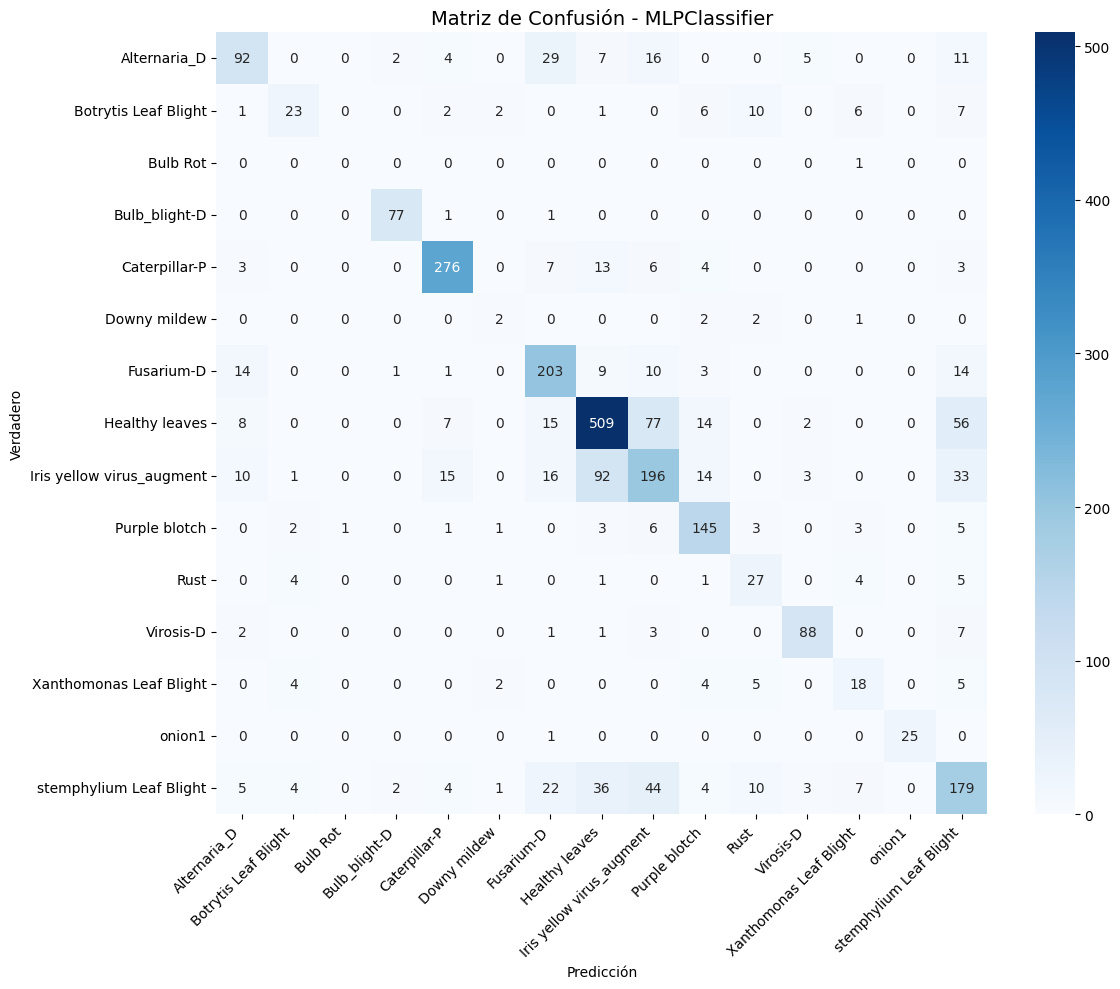

In [51]:
# 7. Visualizar matriz de confusión
visualizar_matriz_confusion(matriz, label_encoder.classes_)



ANÁLISIS DE CURVA DE ENTRENAMIENTO - MLPClassifier


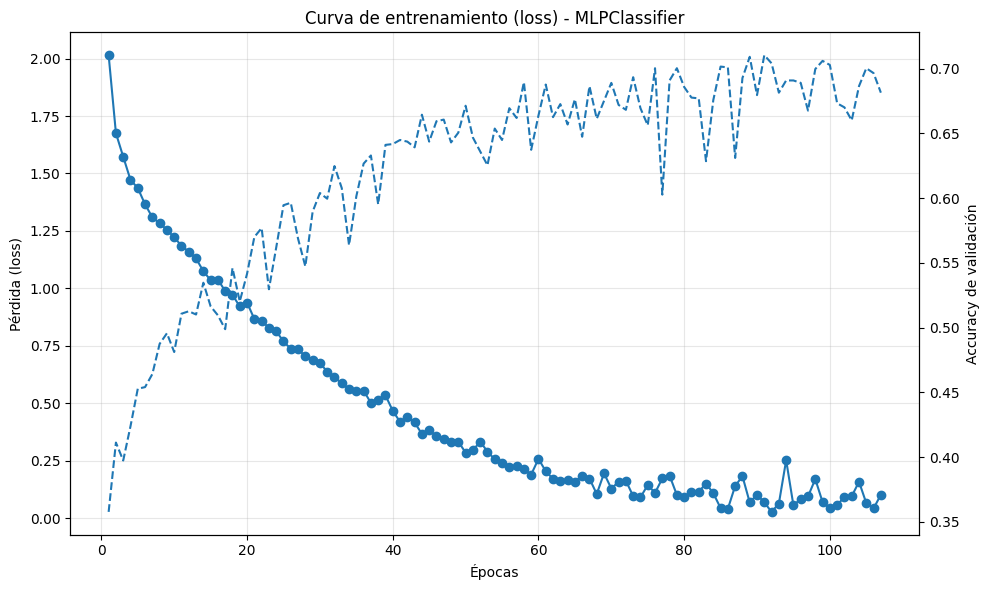

In [52]:
# 8. Visualizar curva de entrenamiento
analizar_curva_entrenamiento(modelo)

In [53]:
# 8. Guardar modelo y LabelEncoder
joblib.dump(modelo,out_dir/'modelo_mlp.pkl')
joblib.dump(label_encoder, out_dir/'label_encoder_mlp.pkl')
print("\nModelo MLP (modelo_mlp.pkl) y LabelEncoder (label_encoder_mlp.pkl) guardados en disco.")


Modelo MLP (modelo_mlp.pkl) y LabelEncoder (label_encoder_mlp.pkl) guardados en disco.


In [54]:
# 9. Accuracy por clase
print("\n" + "=" * 60)
print("ACCURACY POR CLASE")
print("=" * 60)
num_clases = len(label_encoder.classes_)
accuracies_por_clase = []

for i, clase in enumerate(label_encoder.classes_):
    idx = np.where(y_test == i)[0]
    if len(idx) == 0:
        acc_clase = 0.0
    else:
        acc_clase = accuracy_score(y_test[idx], y_pred[idx])
    accuracies_por_clase.append(acc_clase)
    print(f"   {clase}: {acc_clase:.2%}")


ACCURACY POR CLASE
   Alternaria_D: 55.42%
   Botrytis Leaf Blight: 39.66%
   Bulb Rot: 0.00%
   Bulb_blight-D: 97.47%
   Caterpillar-P: 88.46%
   Downy mildew: 28.57%
   Fusarium-D: 79.61%
   Healthy leaves: 73.98%
   Iris yellow virus_augment: 51.58%
   Purple blotch: 85.29%
   Rust: 62.79%
   Virosis-D: 86.27%
   Xanthomonas Leaf Blight: 47.37%
   onion1: 96.15%
   stemphylium Leaf Blight: 55.76%


Predicción con Imagenes de Prueba


PREDICCIÓN PARA UNA NUEVA IMAGEN - MLPClassifier

Clase predicha: Alternaria_D

Top 3 predicciones:
   1. Alternaria_D: 99.66%
   2. Iris yellow virus_augment: 0.22%
   3. Healthy leaves: 0.10%

Confianza de la clase predicha: 99.66%


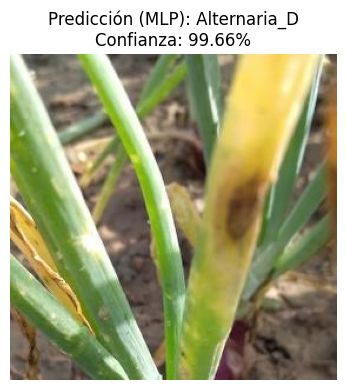

'Alternaria_D'

In [58]:
predecir_imagen("Imagenes_Prueba/Alternaria.jpg")


PREDICCIÓN PARA UNA NUEVA IMAGEN - MLPClassifier

Clase predicha: Downy mildew

Top 3 predicciones:
   1. Downy mildew: 98.58%
   2. stemphylium Leaf Blight: 0.80%
   3. Xanthomonas Leaf Blight: 0.33%

Confianza de la clase predicha: 98.58%


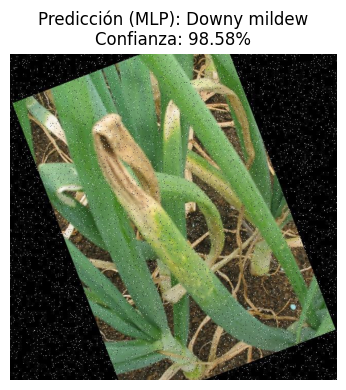

'Downy mildew'

In [59]:
predecir_imagen("Imagenes_Prueba/Downy.jpg")


PREDICCIÓN PARA UNA NUEVA IMAGEN - MLPClassifier

Clase predicha: Iris yellow virus_augment

Top 3 predicciones:
   1. Iris yellow virus_augment: 99.91%
   2. Healthy leaves: 0.09%
   3. Fusarium-D: 0.00%

Confianza de la clase predicha: 99.91%


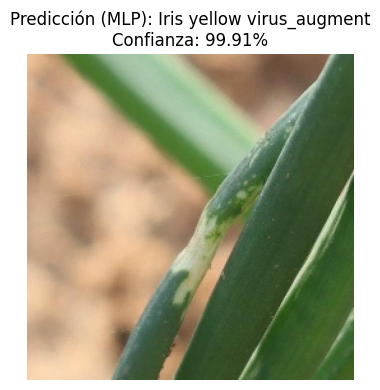

'Iris yellow virus_augment'

In [61]:
predecir_imagen("Imagenes_Prueba/Iris.jpg")


PREDICCIÓN PARA UNA NUEVA IMAGEN - MLPClassifier

Clase predicha: Purple blotch

Top 3 predicciones:
   1. Purple blotch: 93.69%
   2. Caterpillar-P: 5.99%
   3. Healthy leaves: 0.27%

Confianza de la clase predicha: 93.69%


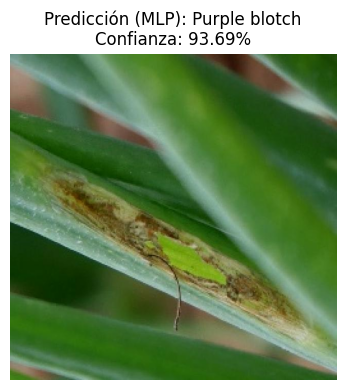

'Purple blotch'

In [62]:
predecir_imagen("Imagenes_Prueba/Purple.jpg")